In [ ]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans  

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import spacy


In [ ]:
books_sample = pd.read_csv('books_data.csv')

In [ ]:
#RESTART RUNTIME BEFORE RUNNING THIS TO LOAD BERT AND RUN ALL CELLS ABOVE THIS
#!!!!!DONOT RUN IT AGAIN AFTER RESTARTING RUNTIME.
import spacy.cli
spacy.cli.download("en_trf_bertbaseuncased_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


In [ ]:
#RESTART RUNTIME BEFORE RUNNING THIS TO LOAD BERT AND RUN ALL CELLS EXCEPT TBE ABOVE ONE
nlp=spacy.load('en_trf_bertbaseuncased_lg')

In [ ]:
def get_embeddinngs(text):
    return nlp(text).vector

In [ ]:
books_sample['emb'] = books_sample['Text'].apply(get_embeddinngs)

In [ ]:
X = np.array(books_sample['emb'].tolist())


In [ ]:
from sklearn.preprocessing import LabelEncoder
y = books_sample['Author']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
books_sample['encoded_author']=y

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30, random_state=42)
X_svd = svd.fit_transform(X)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.75


In [ ]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from sklearn.metrics import silhouette_score

for i in [2, 3, 4, 5,6]:
    gmm = GaussianMixture(n_components=i)
    gmm.fit(X_svd)
    labels=gmm.predict(X_svd)
    score = silhouette_score(X_svd, labels, metric='euclidean')
    print("silhouette coefficient for clusters", score)

silhouette coefficient for clusters 0.2338946
silhouette coefficient for clusters 0.20386717
silhouette coefficient for clusters 0.19435354
silhouette coefficient for clusters 0.19399063
silhouette coefficient for clusters 0.17807505


array([[1.16684503e-10, 2.41234883e-51, 1.00000000e+00, 2.54738032e-17,
        1.68556187e-25],
       [5.56654537e-06, 4.29732278e-75, 9.99994433e-01, 1.45636235e-34,
        8.12809985e-28],
       [2.09721432e-11, 6.32369643e-55, 9.99999999e-01, 1.15524395e-20,
        7.92829380e-10],
       ...,
       [1.00000000e+00, 3.34961626e-39, 4.85730445e-85, 2.46089898e-12,
        2.23642142e-16],
       [8.53248948e-22, 2.17722930e-33, 5.03767537e-66, 1.19926613e-24,
        1.00000000e+00],
       [7.34610708e-24, 9.24181944e-78, 6.81810200e-24, 6.00826707e-23,
        1.00000000e+00]])

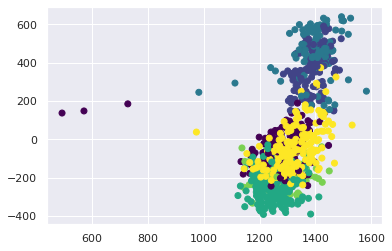

In [ ]:
gmm = GaussianMixture(n_components=5)
gmm_labels=gmm.fit_predict(X_svd, y)
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels, cmap='viridis');

gmm.predict_proba(X_svd)

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, gmm_labels)

0.5150000000000001

In [ ]:
books_sample['gmm_labels']=gmm_labels

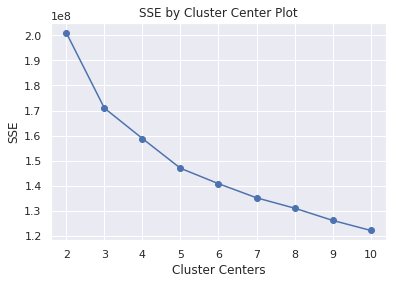

In [ ]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=10).fit(data).inertia_)
        #print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_svd, 10)

In [ ]:
from sklearn.metrics import silhouette_score

for i in [2,3,4,5,6]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=10)
    labels=km.fit_predict(X_svd, y)

    score = silhouette_score(X_svd, labels, metric='euclidean')
    print(score)

0.23513237
0.20800298
0.19817623
0.19703238
0.18372692


In [ ]:
km_labels = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=10).fit_predict(X_svd,y)


In [ ]:
books_sample['km_labels'] = km_labels

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, km_labels)

0.42500000000000004

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch


In [ ]:
def hierarchical_clustering(data, i):
    hc= AgglomerativeClustering(n_clusters=i,  affinity='euclidean', linkage='ward')  
    assigned_clusters= hc.fit_predict(data,y )  
#    data['cluster_hierar'] = pd.Series(assigned_clusters, index=data.index)

    return data, assigned_clusters

In [ ]:
dist = 1 - cosine_similarity(X_svd)
dist = dist - dist.min() # get rid of some pesky floating point errors that give neg. distance

In [ ]:
x = books_sample["Text"] 

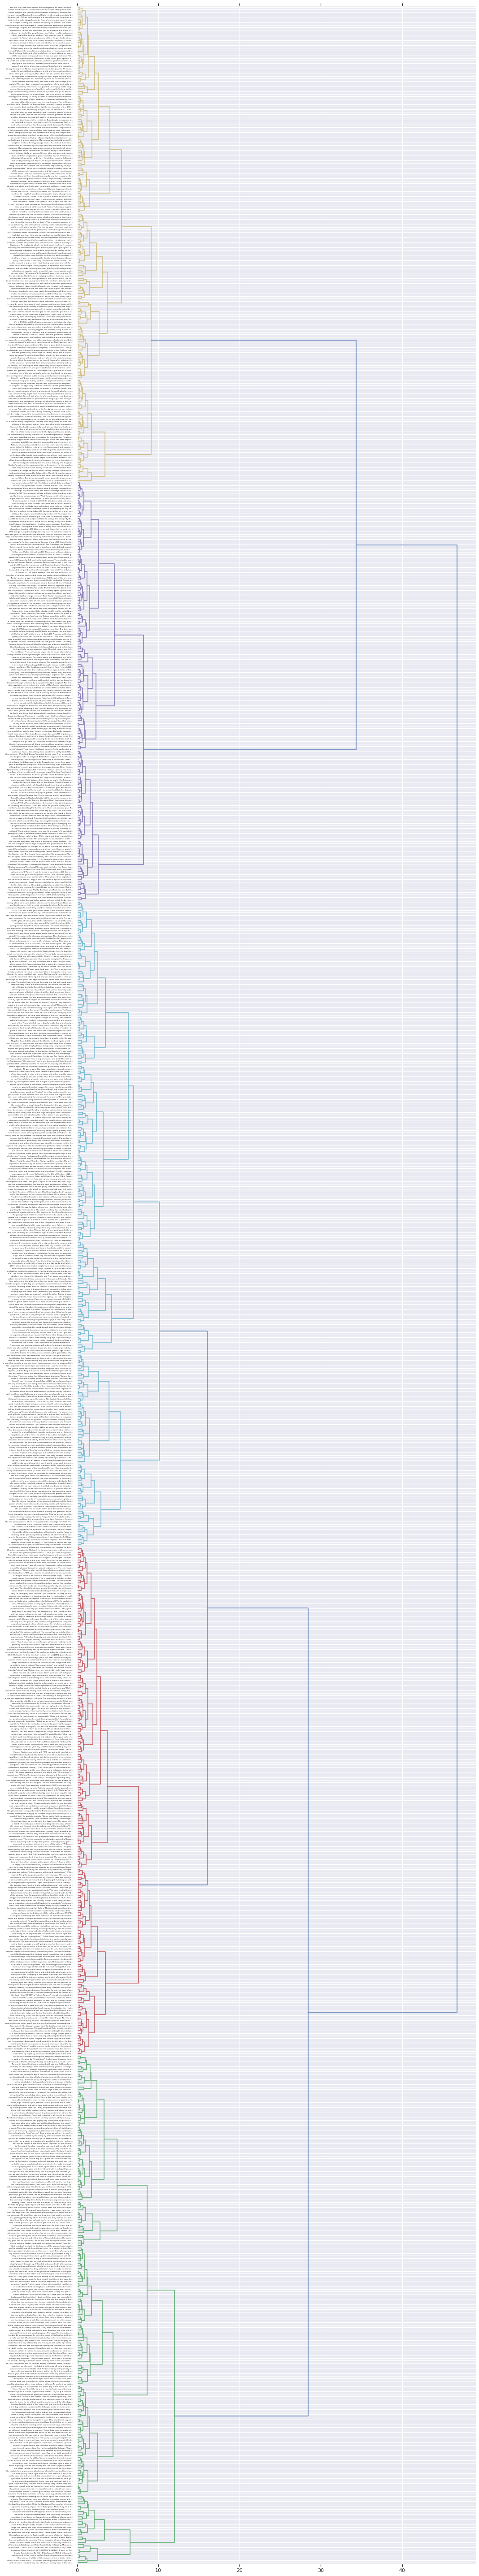

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.29 # max distance between points to be considered together. can be tuned.

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=x.apply(lambda x: x if len(x) < 70 else x[:70  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

In [ ]:
from sklearn.metrics import silhouette_score

for i in [2,3,4,5,6]:
    hc= AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    km= hc.fit(X_svd)  

    score = silhouette_score(X_svd, km.labels_, metric='euclidean')
    print(score)

0.37076667
0.35524312
0.3464514
0.2948345
0.28571948


In [ ]:
hc_labels=hierarchical_clustering(X_svd, 3)[1]

In [ ]:
books_sample['hc_labels']=hc_labels


In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, hc_labels)

-0.006250000000000089

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

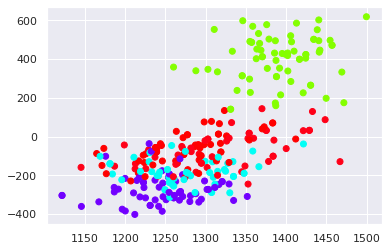

In [ ]:
def plot_scatter(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(data[max_items,:])    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    plt.scatter(svd[idx, 0], svd[idx, 1], c=label_subset)
    plt.show()

In [ ]:
hc= AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit_predict(X)  

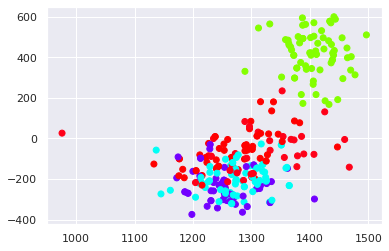

In [ ]:
plot_scatter(X, km_labels)

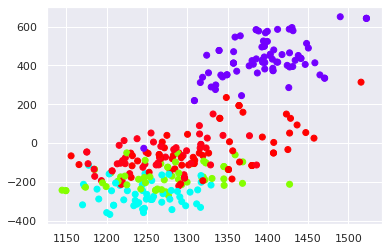

In [ ]:
plot_scatter(X, hc)

In [ ]:
books_sample

,Unnamed: 0,Author,Text,emb,encoded_author,gmm_labels,km_labels,hc_labels
0,0,a,"an invitation from Hartfield , and who were fe...","[-27.166782, -9.981429, 9.506252, -42.613636, ...",0,2,2,2
1,1,a,materially changed since we talked on this sub...,"[18.51912, 19.026007, -1.0067415, -79.264114, ...",0,2,2,2
2,2,a,", gentlemanlike man , whose frequent visits we...","[-5.3324103, 23.174192, 12.685682, -48.925636,...",0,2,2,2
3,3,a,"me , whenever I had an opportunity , to thank ...","[2.6571143, 13.6736, 30.42934, -51.40325, 25.2...",0,2,2,2
4,4,a,such unfortunate circumstances do sometimes oc...,"[-7.3149223, 46.320633, 19.57097, -49.021294, ...",0,2,2,2
...,...,...,...,...,...,...,...,...
995,995,e,"sleeps his meadow , and there sleep his cattle...","[29.488752, 35.77466, 32.15321, -14.373271, 41...",4,1,1,1
996,996,e,the stump ; leaning on a shivered lance ; prop...,"[35.298943, 40.108597, 18.831444, -34.78981, 1...",4,1,1,1
997,997,e,"d ' ye see ; now as you well know , sir , we c...","[51.615543, 28.496866, 22.373388, -47.021873, ...",4,0,3,0
998,998,e,there again ! there she breaches ! right ahead...,"[-3.8712466, 38.326035, -11.975886, -37.105686...",4,4,4,2


In [ ]:
c=0

for i in range(0,999):

  if(books_sample['gmm_labels'][i]!=books_sample['encoded_author'][i]):

    c+=1

print('For GMM ',c)

For GMM  388


In [ ]:
c=0

for i in range(0,999):

  if(books_sample['km_labels'][i]!=books_sample['encoded_author'][i]):

    c+=1

print('For KM ',c)

For KM  460


In [ ]:
c=0

for i in range(0,999):

  if(books_sample['hc_labels'][i]!=books_sample['encoded_author'][i]):

    c+=1

print('For HC ',c)

For HC  804
